# Introduction
In big and old legacy systems, tests are often a mess. Especially end-to-end-tests with UI testing frameworks like Selenium quickly become a PITA aka unmaintainable. They are running slow and you are confronted with plenty of  tests that do partly the same.

In this data analysis, I want to illustrate a way that can take us out of this misery. We want to spot test cases that are structural very similar and thus can be seen as duplicated. We'll calculate the similarity between tests based on their invocations of production code. We can achieve this treating our software data as observations of linear features. This opens up ways for us to leverage existing machine learning techniques like multidimensional scaling or clustering.

As software data under analysis, we'll use the JUnit tests of a Java application for demonstrating the approach. 

_Note: The real use case originates from a software system with a massive amount of Selenium tests that uses the [Page Object pattern](https://martinfowler.com/bliki/PageObject.html). Each page object represents one HTML site of your web application. So, a page object exposes methods in the programming language you use enabling the interaction with a web site programmatically. In such a scenario, you can infer which tests are triggering the same set of UI components (like buttons). This is a good estimator for test cases that test the same use cases in the application. We can use the results of such an analysis to find repeating test scenarios as well as tests that just differ from a minor nuance of an otherwise similar use case (which could probably be tested with other means like integration or pure UI tests with a mocked backend)._

# Dataset

I'm using a dataset that I've created in a previous blog post. It shows which test methods call which code in the main line ("production"). 

_Note: There are also other ways to get this structural information e. g. by mining the log file of a test execution (this would even add real runtime information as well). But for our demo purpose, the pure structural information between the test code and our production code is sufficient._

First, we read in the data with Pandas.

In [1]:
import pandas as pd

invocations = pd.read_csv("datasets/test_code_invocations.csv", sep=";")
invocations.head()

,test_type,test_method,prod_type,prod_method,invocations
0,AddCommentTest,void blankSiteContainsRightComment(),AddComment,at.dropover.comment.boundary.GetCommentRespons...,1
1,AddCommentTest,void blankSiteContainsRightCreationTime(),AddComment,at.dropover.comment.boundary.GetCommentRespons...,1
2,AddCommentTest,void blankSiteContainsRightUser(),AddComment,at.dropover.comment.boundary.GetCommentRespons...,1
3,AddCommentTest,void failsAtCommentNull(),AddComment,at.dropover.comment.boundary.GetCommentRespons...,1
4,AddCommentTest,void failsAtCreatorNull(),AddComment,at.dropover.comment.boundary.GetCommentRespons...,1


What we've got here are all names of our test types (`test_type`) and production types (`prod_type`) as well as the signatures of the test methods (`test_method`) and production methods (`prod_method`). We also have the amount of calls from the test methods to the production methods (`invocations`).

# Analysis
OK, let's do some actual work! We want to calculate the structural similarity of test cases to spot possible duplications of tests.

What we have are all tests cases (aka test methods) and their calls to the production code base (= the production methods). We can transform this data to get a matrix representation that shows which test method triggers which production method by using Pandas' `pivot_table` function on our `invocations` `DataFrame`.

In [2]:

invocation_matrix = invocations.pivot_table(
    index=['test_type', 'test_method'],
    columns=['prod_type', 'prod_method'],
    values='invocations', 
    fill_value=0
)
# show interesting parts of results
invocation_matrix.iloc[4:8,4:6]

prod_type                                                                                                                                                  AddComment  \
prod_method                                          at.dropover.comment.boundary.GetCommentResponseModel doSync(at.dropover.comment.boundary.AddCommentRequestModel)   
test_type             test_method                                                                                                                                       
AddCommentTest        void failsAtCreatorNull()                                                       1                                                                 
                      void worksAtMinimalRequest()                                                    1                                                                 
AddSchedulingDateTest void addDateToScheduling()                                                      0                                                                 
                      void addTwoDatesToScheduling()                                                  0                                                                 

prod_type                                                                                                                                                           AddScheduling  
prod_method                                          at.dropover.scheduling.boundary.AddSchedulingResponseModel doSync(at.dropover.scheduling.boundary.AddSchedulingRequestModel)  
test_type             test_method                                                                                                                                                  
AddCommentTest        void failsAtCreatorNull()                                                       0                                                                            
                      void worksAtMinimalRequest()                                                    0                                                                            
AddSchedulingDateTest void addDateToScheduling()                                                      0                                                                            
                      void addTwoDatesToScheduling()                                                  0

What we've got now is the information for each invocation (or non-invocation) of test methods to production methods. In mathematical words, we've got now a __n-dimensional vector for each test method__ where n is the number of tested production methods in our code base! That means we've just transformed our software data to a representation that we can now work on with standard Data Science tools :-D! That means all further problem solving techniques in this area can be reused by us. 

This is exactly what we do now in our further analysis. We reduced our problem to a distance calculation between vectors (we use distance instead of similarity because later used visualization techniques work with distances). For this, we can use the `cosine_distances` function of the machine learning library [http://scikit-learn.org](scikit-learn) to calculate a pair-wise distance matrix between the test methods.

In [3]:
from sklearn.metrics.pairwise import cosine_distances

distance_matrix = cosine_distances(invocation_matrix)
# show some interesting parts of results
distance_matrix[81:85,60:62]

array([[ 0.10557281,  0.2       ],
       [ 0.10557281,  0.2       ],
       [ 0.80388386,  0.8245884 ],
       [ 1.        ,  1.        ]])

From this data, we create a `DataFrame` to get a better representation. You can find the complete `DataFrame` here as excel file as well.

In [4]:
distance_df = pd.DataFrame(distance_matrix, index=invocation_matrix.index, columns=invocation_matrix.index)
# show some interesting parts of results
distance_df.iloc[81:85,60:62]

test_type                                                                             CommentGatewayTest  \
test_method                                                        void readRoundtripWorksWithFullData()   
test_type             test_method                                                                          
CommentsResourceTest  void postCommentActuallyCreatesComment()                                  0.105573   
                      void postCommentActuallyCreatesCommentJSON()                              0.105573   
                      void postTwiceCreatesTwoElements()                                        0.803884   
ConfigurationFileTest void keyWorks()                                                           1.000000   

test_type                                                                                                      
test_method                                                        void readRoundtripWorksWithMandatoryData()  
test_type             test_method                                                                              
CommentsResourceTest  void postCommentActuallyCreatesComment()                                       0.200000  
                      void postCommentActuallyCreatesCommentJSON()                                   0.200000  
                      void postTwiceCreatesTwoElements()                                             0.824588  
ConfigurationFileTest void keyWorks()                                                                1.000000

In [5]:
invocations[
    (invocations.test_method == "void readRoundtripWorksWithFullData()") |
    (invocations.test_method == "void postCommentActuallyCreatesComment()")]

,test_type,test_method,prod_type,prod_method,invocations
112,CommentGatewayTest,void readRoundtripWorksWithFullData(),CommentGateway,java.util.List read(java.lang.String),2
147,CommentsResourceTest,void postCommentActuallyCreatesComment(),Comment,java.lang.String getContent(),1
148,CommentsResourceTest,void postCommentActuallyCreatesComment(),CommentGateway,java.util.List read(java.lang.String),2


In [6]:
invocations[
    (invocations.test_method == "void readRoundtripWorksWithFullData()") |
    (invocations.test_method == "void postTwiceCreatesTwoElements()")]

,test_type,test_method,prod_type,prod_method,invocations
112,CommentGatewayTest,void readRoundtripWorksWithFullData(),CommentGateway,java.util.List read(java.lang.String),2
151,CommentsResourceTest,void postTwiceCreatesTwoElements(),Comment,java.lang.String getContent(),5
152,CommentsResourceTest,void postTwiceCreatesTwoElements(),CommentGateway,java.util.List read(java.lang.String),1


# Visualization
Our now 422x422 big distance matrix `distance_df` isn't a good way to spot similarities very well. Let's break down the result into two dimensions using multidimensional scaling (`MDS`) from scikit-learn and plot the results with the plotting library `matplotlib`.

MDS tries to find a representation of our 422-dimensional data set into the two-dimensional space while retaining the distance information between all data points (=test methods). We use the `MDS` technique with our precomputed dissimilarity matrix `distance_df`.

In [7]:
from sklearn.manifold import MDS

model = MDS(dissimilarity='precomputed', random_state=10)
distance_df_2d = model.fit_transform(distance_df)
distance_df_2d[:5]

array([[-0.02495802,  0.10768622],
       [ 0.34902428,  0.58676902],
       [-0.0249776 ,  0.10768132],
       [-0.26850959,  0.32472212],
       [-0.02497707,  0.10768145]])

Next, we plot the now two-dimensional matrix with `matplotlib`. We colorize all data points according to the name of the test types. We can achieve this by assigning each type a number within 0 and 1 (`relative_index`) and draw a color from a predefined color spectrum (`cm.hsv`) for each type. With this, each test class gets its own color. This enables us to quickly reason about test classes that belong together.

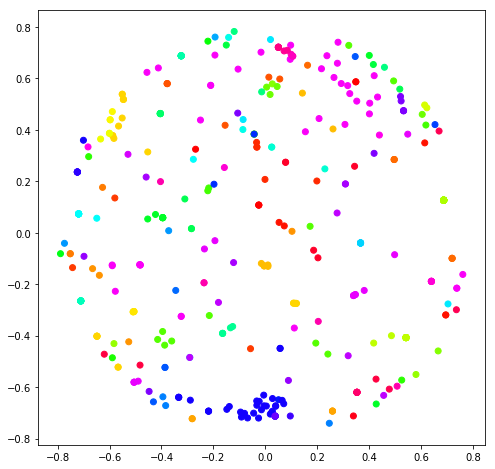

In [8]:
%matplotlib inline
from matplotlib import cm
import matplotlib.pyplot as plt

relative_index = distance_df.index.labels[0].values() / distance_df.index.labels[0].max()
colors = [x for x in cm.hsv(relative_index)]
plt.figure(figsize=(8,8))
x = distance_df_2d[:,0]
y = distance_df_2d[:,1]
plt.scatter(x, y, c=colors)

We now have the visual information about which test methods call similar production code! Let's discuss this plot:
* Groups of data points (aka clusters) of the same color are the good ones (like the blue colored ones in the lower middle). They show that there is a high cohesion of test methods with test classes that test the corresponding production code.
* Clusters with mixed colored data points (like in the upper middle) require further analysis. Here, different test classes test the similar production code

Let's quickly find those spots programmatically by using another machine learning technique: density-based clustering! Here, we use `DBSCAN` to find data points that are close together. We plot this information into the plot above to visualize dense groups of data.

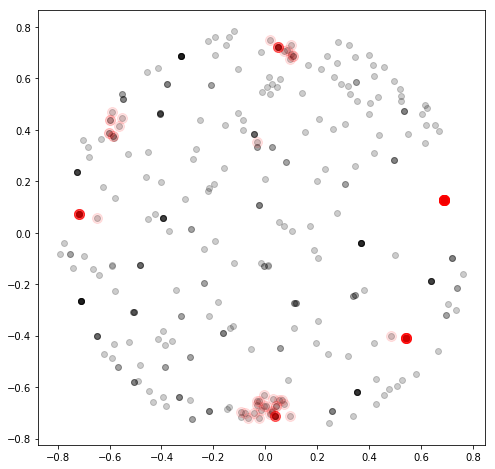

In [9]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.08, min_samples=10)
clustering_results = dbscan.fit(distance_df_2d)
plt.figure(figsize=(8,8))
cluster_members = clustering_results.components_

# plot all data points
plt.scatter(x, y, c='k', alpha=0.2)

# plot cluster members
plt.scatter(
    cluster_members[:,0],
    cluster_members[:,1],
    c='r', s=100, alpha=0.1)

In [10]:
tests = pd.DataFrame(index=distance_df.index)
tests['cluster'] = clustering_results.labels_
cohesive_tests = tests[tests.cluster != -1]
cohesive_tests.head()

cluster
test_type          test_method                                     
AddSchedulingTest  void add2EmptySchedulingWidgetsToSite()        0
                   void addEmptySchedulingWidgetToSite()          0
                   void failsIfPositionIsNull()                   0
AddTodoTest        void addedTodoIsPersisted()                    4
CommentGatewayTest void readFailsOnNullSite()                     1

In [11]:
test_measures = cohesive_tests.reset_index().groupby("cluster").test_type.agg({"nunique", "count"})
test_measures

,nunique,count
cluster,,
0,7,10
1,3,16
2,1,19
3,1,31
4,7,17
5,1,12
6,6,32


In [12]:
test_list = cohesive_tests.reset_index().groupby("cluster").test_type.apply(set)
test_list

cluster
0    {AddSchedulingTest, GetSchedulingsTest, Delete...
1    {CommentResourceTest, CommentGatewayTest, Comm...
2                                     {CreateSiteTest}
3                                 {CreateTimeDiffTest}
4    {TodoResourceTest, GetTodoListTest, TodoGatewa...
5                                        {GetSiteTest}
6    {SchedulingDateResourceTest, SchedulingDatesRe...
Name: test_type, dtype: object

In [13]:
test_analysis_result = test_measures.join(test_list)
test_analysis_result

,nunique,count,test_type
cluster,,,
0,7,10,"{AddSchedulingTest, GetSchedulingsTest, Delete..."
1,3,16,"{CommentResourceTest, CommentGatewayTest, Comm..."
2,1,19,{CreateSiteTest}
3,1,31,{CreateTimeDiffTest}
4,7,17,"{TodoResourceTest, GetTodoListTest, TodoGatewa..."
5,1,12,{GetSiteTest}
6,6,32,"{SchedulingDateResourceTest, SchedulingDatesRe..."


In [14]:
test_analysis_result.iloc[0].test_type

{'AddSchedulingTest',
 'DeleteTodoListTest',
 'DeleteTodoTest',
 'DownloadFileTest',
 'GetSchedulingTest',
 'GetSchedulingsTest',
 'ReportAbuseTest'}

# Conclusion
What a trip! We've started from a data set that showed us the invocations of production methods by test methods. We also went our way deep through the three mathematical / machine learning techniques `cosine_distances`, `MDS` and `DBSCAN`. Finally, we've found out which different test class classes test the same production code. The result is a helpful starting point to reorganizing your tests.

In general, we saw how we can transform software specific problems to questions that can be answered by using standard Data Science tooling.